**SVM_Undersampling with Aggregation- Permutation Importance and RFE**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Random seed for reproducibility
np.random.seed(17)

In [2]:
# ===================== LOAD AND CLEAN DATA =====================
data_ksi = pd.read_csv("./Total_KSI.csv")

# Initial data overview
"""Displays an overview of the dataset."""
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

print("\n===================== DATA OVERVIEW =====================")
print("\nFirst 3 Records:\n", data_ksi.head(3))
print("\nShape of the DataFrame:", data_ksi.shape)
print("\nData Types:\n", data_ksi.dtypes)

print("\n===================== DATA DESCRIPTION =====================")
print("\nStatistical Summary:\n", data_ksi.describe())

print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()

print("\n===================== MISSING VALUES =====================")
missing_data = data_ksi.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_data / len(data_ksi)) * 100
print(pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing']))

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())

print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column} ({len(data_ksi[column].unique())}):", data_ksi[column].unique())


# Drop unnecessary columns

columns_to_drop = [ 'OBJECTID', 'INDEX',  # index_id 
    'FATAL_NO', # sequence No. - high missing values
    'OFFSET', #high missing values
    'x', 'y','CYCLISTYPE', 'PEDTYPE', 'PEDACT', # high correlation
    'EMERG_VEH',       # 0 permutation importance 
    'CYCCOND',         # 0 permutation importance 
    "NEIGHBOURHOOD_158","NEIGHBOURHOOD_140","STREET1","STREET2","INJURY"
]




===================== DATA OVERVIEW =====================

First 3 Records:
    OBJECTID    INDEX    ACCNUM                  DATE  TIME       STREET1  \
0         1  3389067  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
1         2  3389068  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   
2         3  3389069  893184.0  1/1/2006 10:00:00 AM   236  WOODBINE AVE   

       STREET2 OFFSET      ROAD_CLASS               DISTRICT   LATITUDE  \
0  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
1  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   
2  O CONNOR DR    NaN  Major Arterial  Toronto and East York  43.699595   

   LONGITUDE                ACCLOC    TRAFFCTL VISIBILITY LIGHT RDSFCOND  \
0 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
1 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   
2 -79.318797  Intersection Related  No Control      Clear  Dark      Wet   

           

In [3]:
# Drop unnecessary columns
data_ksi.drop(columns=columns_to_drop, inplace=True)

# Handle missing target values and specific rows
data_ksi['ACCLASS'] = data_ksi['ACCLASS'].fillna('Fatal')
data_ksi.drop(data_ksi[data_ksi['ACCLASS'] == 'Property Damage O'].index, inplace=True)
data_ksi.drop_duplicates(inplace=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


Class Distribution:
 ACCLASS
Non-Fatal Injury    15568
Fatal                2537
Name: count, dtype: int64


In [4]:
def aggregate_rows(group):
    # Find the row with the maximum number of non-null values in the non-'Fatal' group
    max_non_null_row_idx = group.notnull().sum(axis=1).idxmax()
    max_non_null_row = group.loc[max_non_null_row_idx].copy()  
    
    # Apply aggregation based on the column type (mean for numerical, mode for categorical)
    for col in max_non_null_row.index:
        if pd.api.types.is_numeric_dtype(group[col]):
            # For numerical columns, apply the mean
            mean_value = group[col].mean()
            max_non_null_row[col] = mean_value
        else:
            # For categorical columns, apply the mode
            mode_value = group[col].mode().iloc[0] if not group[col].mode().empty else None
            max_non_null_row[col] = mode_value
    
    # Return the processed non-Fatal row
    return max_non_null_row.to_frame().T

In [5]:
# Separate fatal rows
fatal_rows = data_ksi[data_ksi['ACCLASS'] == 'Fatal']

# Separate non-fatal rows
non_fatal_rows = data_ksi[data_ksi['ACCLASS'] != 'Fatal']

# Apply aggregation logic on non-fatal rows based on ACCNUM
aggregated_data = non_fatal_rows.groupby(['ACCNUM'], as_index=False).apply(aggregate_rows, include_groups=False).reset_index(drop=True)

# Combine the aggregated data with the fatal rows
data_ksi = pd.concat([aggregated_data, fatal_rows], ignore_index=True)

# Shuffle the combined data
data_ksi = data_ksi.sample(frac=1, random_state=42).reset_index(drop=True)

print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())


Class Distribution:
 ACCLASS
Non-Fatal Injury    4324
Fatal               2537
Name: count, dtype: int64


In [6]:
# Map month numbers to seasons using the MONTH column
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

In [7]:
# Format date and time
data_ksi["DATE"] = pd.to_datetime(data_ksi["DATE"]).dt.to_period("D").astype(str)

# Extract date components from the 'DATE' column
data_ksi['MONTH'] = pd.to_datetime(data_ksi['DATE']).dt.month

# Extract season
data_ksi['SEASON'] = data_ksi['MONTH'].apply(month_to_season).astype(float)

# Replace specific values
data_ksi['ROAD_CLASS'] = data_ksi['ROAD_CLASS'].str.replace(r'MAJOR ARTERIAL ', 'MAJOR ARTERIAL', regex=False)

# Fill missing values
unknown_columns = ['PEDCOND', 'DRIVCOND', 'MANOEUVER', 'CYCACT',
                    'VEHTYPE', 'INVTYPE', 'IMPACTYPE', 'DISTRICT', 'INITDIR']
other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'DRIVACT']
boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'MOTORCYCLE',
                   'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'TRSN_CITY_VEH', 'DISABILITY','AUTOMOBILE','TRUCK']

data_ksi[boolean_columns] = data_ksi[boolean_columns].fillna("No")

data_ksi['INVAGE'] = data_ksi['INVAGE'].fillna("unknown")

# Handle age column
data_ksi['INVAGE'] = data_ksi['INVAGE'].replace('unknown', np.nan)
data_ksi['INVAGE'] = data_ksi['INVAGE'].str.replace('OVER 95', '95 to 100')
data_ksi[['min_age', 'max_age']] = data_ksi['INVAGE'].str.split(' to ', expand=True)
data_ksi['min_age'] = pd.to_numeric(data_ksi['min_age'], errors='coerce')
data_ksi['max_age'] = pd.to_numeric(data_ksi['max_age'], errors='coerce')
data_ksi['AVG_AGE'] = data_ksi[['min_age', 'max_age']].mean(axis=1).astype(float)

data_ksi.drop(columns=['INVAGE','min_age', 'max_age'], inplace=True)
data_ksi[other_columns] = data_ksi[other_columns].fillna("Other")
data_ksi[unknown_columns] = data_ksi[unknown_columns].fillna("Unknown")

# Convert boolean columns to numeric
pd.set_option('future.no_silent_downcasting', True)
data_ksi[boolean_columns] = data_ksi[boolean_columns].replace({'Yes': 1, 'No': 0}).astype(float)

data_ksi["TRAFFCTL"] = data_ksi["TRAFFCTL"].fillna("No_Control")


In [8]:
data_ksi['DIVISION'] = data_ksi['DIVISION'].replace('NSA', '00')
data_ksi["DIVISION"] = data_ksi["DIVISION"].str[1:].astype(float)

In [9]:
data_ksi["HOOD_158"] = data_ksi["HOOD_158"].replace('NSA', '00')
data_ksi["HOOD_158"] = data_ksi["HOOD_158"].astype(float)

data_ksi["HOOD_140"] = data_ksi["HOOD_140"].replace('NSA', '00')
data_ksi["HOOD_140"] = data_ksi["HOOD_140"].astype(float)

In [10]:
# Apply the function to extract hours and minutes
data_ksi['HOUR'] = data_ksi['TIME'].apply(lambda x: f"{int(x) // 100:02d}" if x >= 100 else '00')  # Extract hours for 3 or 4 digits
data_ksi['MINUTE'] = data_ksi['TIME'].apply(lambda x: f"{int(x) % 100:02d}" if x >= 100 else f"{int(x):02d}")  # Extract minutes

data_ksi['HOUR'] = data_ksi['HOUR'].astype(int)
data_ksi['MINUTE'] = data_ksi['MINUTE'].astype(int)
data_ksi['LATITUDE'] = data_ksi['LATITUDE'].astype(float)

In [11]:
data_ksi['LONGITUDE'] = data_ksi['LONGITUDE'].astype(float)

data_ksi.drop(columns=['TIME','DATE','MONTH','ACCNUM'], inplace=True)

from imblearn.under_sampling import RandomUnderSampler
# Handle class imbalance
rus = RandomUnderSampler(random_state=17)
X_res, y_res = rus.fit_resample(data_ksi.drop(columns=['ACCLASS']), data_ksi['ACCLASS'])
data_ksi = pd.concat([X_res, y_res], axis=1).sample(frac=1, random_state=17).reset_index(drop=True)

print("\n===================== DATA CLEANING DONE =====================")
print("\nShape of the DataFrame after cleaning:", data_ksi.shape)
print("Class Distribution:\n", data_ksi['ACCLASS'].value_counts())

print("\n===================== COLUMN INFORMATION =====================")
data_ksi.info()


===================== DATA CLEANING DONE =====================

Shape of the DataFrame after cleaning: (5074, 38)
Class Distribution:
 ACCLASS
Non-Fatal Injury    2537
Fatal               2537
Name: count, dtype: int64

===================== COLUMN INFORMATION =====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5074 entries, 0 to 5073
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ROAD_CLASS     5074 non-null   object 
 1   DISTRICT       5074 non-null   object 
 2   LATITUDE       5074 non-null   float64
 3   LONGITUDE      5074 non-null   float64
 4   ACCLOC         5074 non-null   object 
 5   TRAFFCTL       5074 non-null   object 
 6   VISIBILITY     5074 non-null   object 
 7   LIGHT          5074 non-null   object 
 8   RDSFCOND       5074 non-null   object 
 9   IMPACTYPE      5074 non-null   object 
 10  INVTYPE        5074 non-null   object 
 11  INITDIR        5074 non-null   o

In [12]:
print("\n===================== UNIQUE VALUES =====================")
for column in data_ksi.columns:
    print(f"\nUnique values in {column}:", data_ksi[column].unique())


===================== UNIQUE VALUES =====================

Unique values in ROAD_CLASS: ['Major Arterial' 'Minor Arterial' 'Collector' 'Local' 'Other'
 'Expressway' 'Laneway' 'Major Arterial ' 'Expressway Ramp' 'Pending']

Unique values in DISTRICT: ['Etobicoke York' 'Scarborough' 'North York' 'Toronto and East York'
 'Unknown']

Unique values in LATITUDE: [43.699745 43.812186 43.81296  ... 43.720385 43.620945 43.782744]

Unique values in LONGITUDE: [-79.547989 -79.204555 -79.243068 ... -79.41009  -79.23449  -79.42139 ]

Unique values in ACCLOC: ['Other' 'Non Intersection' 'At Intersection' 'Intersection Related'
 'At/Near Private Drive' 'Underpass or Tunnel' 'Overpass or Bridge'
 'Laneway' 'Private Driveway']

Unique values in TRAFFCTL: ['Stop Sign' 'No Control' 'Traffic Signal' 'Traffic Controller'
 'No_Control' 'Traffic Gate' 'Pedestrian Crossover' 'Yield Sign'
 'Streetcar (Stop for)' 'Police Control']

Unique values in VISIBILITY: ['Snow' 'Clear' 'Rain' 'Freezing Rain' 'Fog, Mist,

In [13]:
# ===================== DEFINE PARAMETER GRIDS =====================
# SVM hyperparameter grid 
param_grid_svm = [
        {'svm__kernel': ['linear'], 'svm__C': [1]},  # linear kernel    
        #{'svm__kernel': ['rbf'], 'svm__C': [1], 'svm__gamma': [0.3]},  # rbf kernel 
        #{'svm__kernel': ['poly'], 'svm__C': [10], 'svm__gamma': [1.0], 'svm__degree': [3]}  # poly kernel 
    ]

features = data_ksi.drop(columns=["ACCLASS"])
target = data_ksi["ACCLASS"]

unseen_features = features[-10:]
unseen_labels = target[-10:]

features = features[:-10]
target = target[:-10]

cleaned_df = data_ksi.drop(data_ksi.index[-10:])

# Encode the target variable
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

# Encode unseen labels
unseen_labels = label_encoder.transform(unseen_labels)

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data into train & test
X_train, X_test, y_train, y_test = train_test_split(
        features, target, stratify=target, test_size=0.2, random_state=17)

# Preprocess the data
num_features = features.select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = features.select_dtypes(include=['object']).columns.tolist()

print("\n===================== FEATURES INFO =====================")
print("\nNumerical Features:", num_features)
print("\nCategorical Features:", cat_features)

num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='mode')),
        ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

preprocessor = ColumnTransformer([
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

pipe_svm_ksi = Pipeline([
            ('preprocessor', preprocessor),
            ('svm', SVC(random_state=17))
        ])



===================== FEATURES INFO =====================

Numerical Features: ['LATITUDE', 'LONGITUDE', 'PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'HOOD_158', 'HOOD_140', 'DIVISION', 'SEASON', 'AVG_AGE', 'HOUR', 'MINUTE']

Categorical Features: ['ROAD_CLASS', 'DISTRICT', 'ACCLOC', 'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDCOND', 'CYCACT']


In [15]:
grid_search = GridSearchCV(estimator=pipe_svm_ksi, param_grid=param_grid_svm, scoring='accuracy', refit=True, verbose=3)

In [16]:
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ......svm__C=1, svm__kernel=linear;, score=0.909 total time=   1.9s
[CV 2/5] END ......svm__C=1, svm__kernel=linear;, score=0.909 total time=   1.7s
[CV 3/5] END ......svm__C=1, svm__kernel=linear;, score=0.895 total time=   2.3s
[CV 4/5] END ......svm__C=1, svm__kernel=linear;, score=0.893 total time=   2.0s
[CV 5/5] END ......svm__C=1, svm__kernel=linear;, score=0.899 total time=   2.0s


In [17]:
from model_performance import ModelPerformance
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score

# Predict using the best model
y_pred = best_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

modelPerformance = ModelPerformance(best_model, X_test, y_test)

# Print classification report for detailed performance metrics
print("\n===================== CLASSIFICATION REPORT =====================")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

#Precison, Recall, F1-Score
print("\n===================== PRECISION, RECALL, F1-SCORE =====================")
print("\nPrecision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred, average='weighted'))


===================== CLASSIFICATION REPORT =====================

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       506
           1       0.90      0.89      0.90       507

    accuracy                           0.90      1013
   macro avg       0.90      0.90      0.90      1013
weighted avg       0.90      0.90      0.90      1013


===================== PRECISION, RECALL, F1-SCORE =====================

Precision: 0.8983616267769894
Recall: 0.8983218163869694
F1-Score: 0.8983198346516217
ROC-AUC Score: 0.8983265897981616


In [18]:
print("\n===================== BEST MODEL METRICS =====================")
print("\nBest Parameters:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
print("Best Training Accuracy:", grid_search.best_score_)

accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

import joblib

# Save the model
joblib.dump(best_model, "./best_model.pkl")
print("\nModel saved successfully.")


===================== BEST MODEL METRICS =====================

Best Parameters: {'svm__C': 1, 'svm__kernel': 'linear'}
Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'PEDESTRIAN', 'CYCLIST',
                                                   'AUTOMOBILE', 'MOTORCYCLE',
                                                   'TRUCK', 'TRSN_CITY_VEH',
                                                   'PASSENGER', 'SPEEDING',
                                            

In [19]:
 # Handling unseen data
best_model.fit(unseen_features, unseen_labels)
unseen_predictions = best_model.predict(unseen_features)
unseen_accuracy = best_model.score(unseen_features, unseen_labels)

print("\n===================== UNSEEN DATA METRICS =====================")
print("\nUnseen Predictions:", unseen_predictions)
for i in range(len(unseen_features)):
    print(f"Predicted: {unseen_predictions[i]} Actual: {unseen_labels[i]}")

print(f"Unseen Data Accuracy: {unseen_accuracy:.4f}")


===================== UNSEEN DATA METRICS =====================

Unseen Predictions: [1 1 1 0 0 1 0 0 0 1]
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 0 Actual: 0
Predicted: 1 Actual: 1
Unseen Data Accuracy: 1.0000


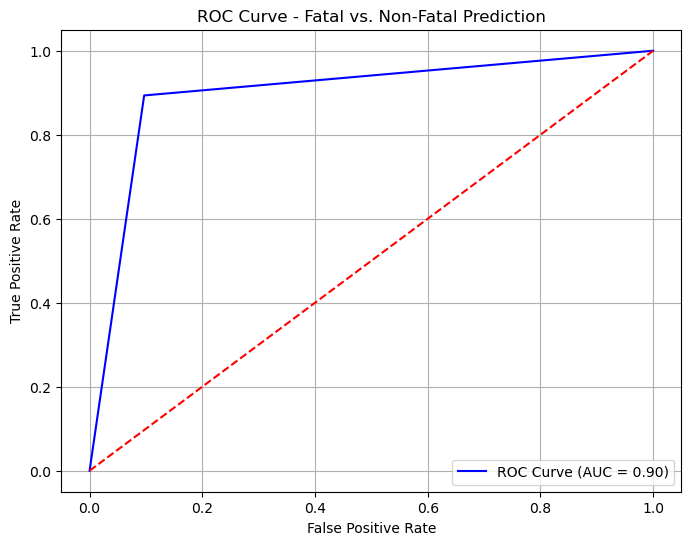

In [20]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred):.2f})', color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve - Fatal vs. Non-Fatal Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

          Feature  Importance Mean  Importance Std
0       LONGITUDE        -0.011451        0.004397
1        DISTRICT        -0.010859        0.004714
2         CYCLIST        -0.007700        0.001810
3        HOOD_140        -0.005133        0.001579
4           LIGHT        -0.004541        0.002619
5        SPEEDING        -0.003356        0.002033
6        LATITUDE        -0.003159        0.001451
7            HOUR        -0.002962        0.002574
8          CYCACT        -0.002962        0.001529
9         AVG_AGE        -0.002369        0.002126
10         MINUTE        -0.001777        0.002199
11       RDSFCOND        -0.001777        0.001451
12         SEASON        -0.001579        0.002302
13      IMPACTYPE        -0.001579        0.002126
14     VISIBILITY        -0.001185        0.001310
15       TRAFFCTL        -0.000592        0.001477
16        PEDCOND        -0.000197        0.001579
17        ALCOHOL         0.000000        0.000000
18  TRSN_CITY_VEH         0.000

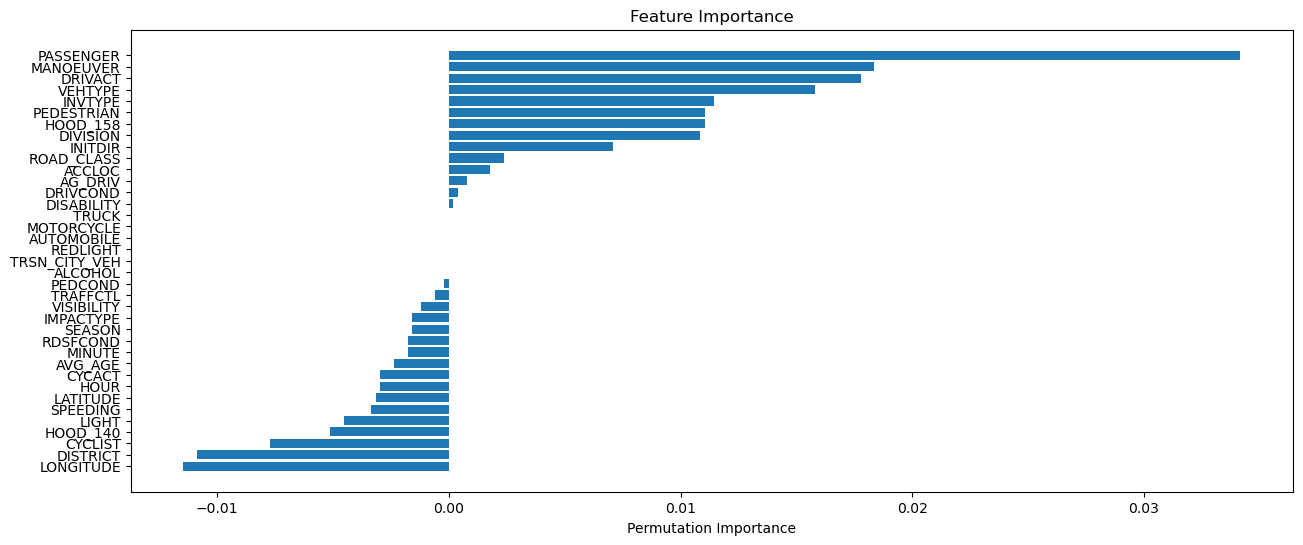

In [21]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_names = features.columns if hasattr(features, 'columns') else [f"Feature {i}" for i in range(features.shape[1])]

perm_importance = permutation_importance(best_model, X_test, y_test)

sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance Mean": perm_importance.importances_mean[sorted_idx],
    "Importance Std": perm_importance.importances_std[sorted_idx]
})

print(importance_df)

# Plot permutation importance
plt.figure(figsize=(15, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

          Feature  Importance Mean  Importance Std
0         CYCLIST        -0.011405        0.001927
1       LONGITUDE        -0.007356        0.003328
2        DISTRICT        -0.003258        0.002651
3        HOOD_140        -0.002320        0.000918
4           LIGHT        -0.002271        0.001183
5        SPEEDING        -0.002222        0.001918
6         AVG_AGE        -0.001481        0.001024
7        LATITUDE        -0.000741        0.001024
8          CYCACT        -0.000741        0.000349
9          MINUTE        -0.000148        0.001054
10           HOUR        -0.000099        0.000458
11        ALCOHOL         0.000000        0.000000
12       REDLIGHT         0.000000        0.000000
13  TRSN_CITY_VEH         0.000000        0.000000
14          TRUCK         0.000000        0.000000
15     MOTORCYCLE         0.000000        0.000000
16     AUTOMOBILE         0.000000        0.000000
17     VISIBILITY         0.000197        0.000185
18         ACCLOC         0.000

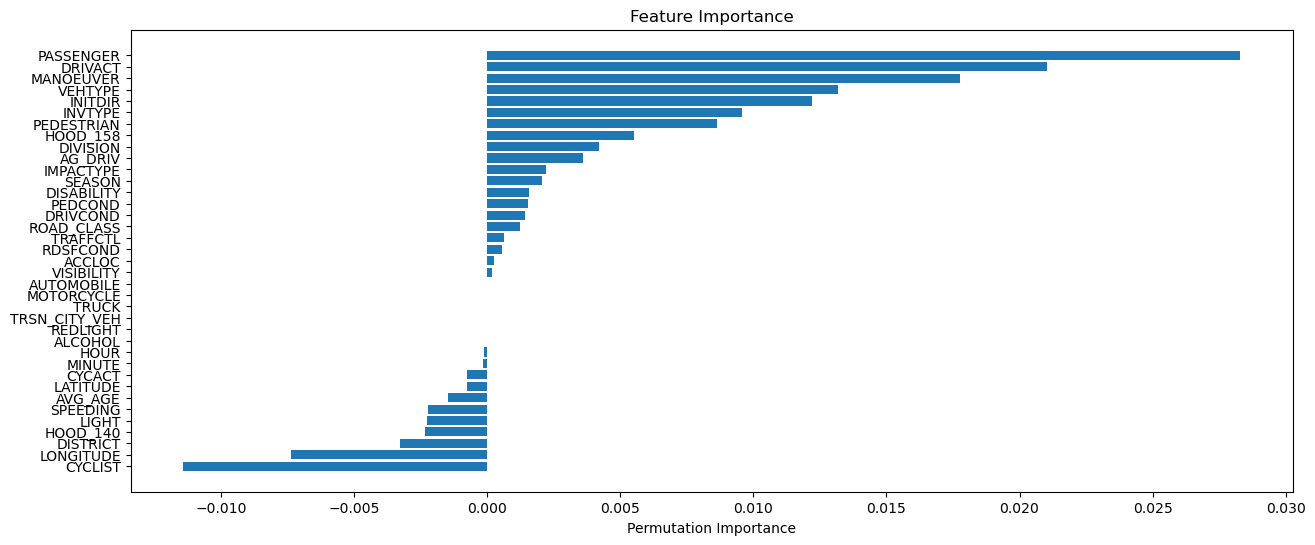

In [30]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

feature_names = features.columns if hasattr(features, 'columns') else [f"Feature {i}" for i in range(features.shape[1])]

perm_importance = permutation_importance(best_model, X_train, y_train)

sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance Mean": perm_importance.importances_mean[sorted_idx],
    "Importance Std": perm_importance.importances_std[sorted_idx]
})

print(importance_df)

# Plot permutation importance
plt.figure(figsize=(15, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.show()

          Feature  Importance
0       PASSENGER    0.023994
1         DRIVACT    0.023994
2       MANOEUVER    0.018267
3         VEHTYPE    0.014169
4         CYCLIST    0.011849
5         INVTYPE    0.009726
6       LONGITUDE    0.008590
7      PEDESTRIAN    0.008344
8         INITDIR    0.008344
9        DIVISION    0.006566
10       DISTRICT    0.006221
11        AG_DRIV    0.003604
12           HOUR    0.003160
13       DRIVCOND    0.002419
14          LIGHT    0.002370
15      IMPACTYPE    0.002222
16     ROAD_CLASS    0.001876
17       SPEEDING    0.001728
18        PEDCOND    0.001432
19       HOOD_140    0.001382
20        AVG_AGE    0.001382
21       LATITUDE    0.001333
22     DISABILITY    0.001234
23         CYCACT    0.001037
24       HOOD_158    0.000839
25     VISIBILITY    0.000494
26       TRAFFCTL    0.000444
27         MINUTE    0.000444
28         SEASON    0.000346
29         ACCLOC    0.000197
30       RDSFCOND    0.000049
31     MOTORCYCLE    0.000000
32        

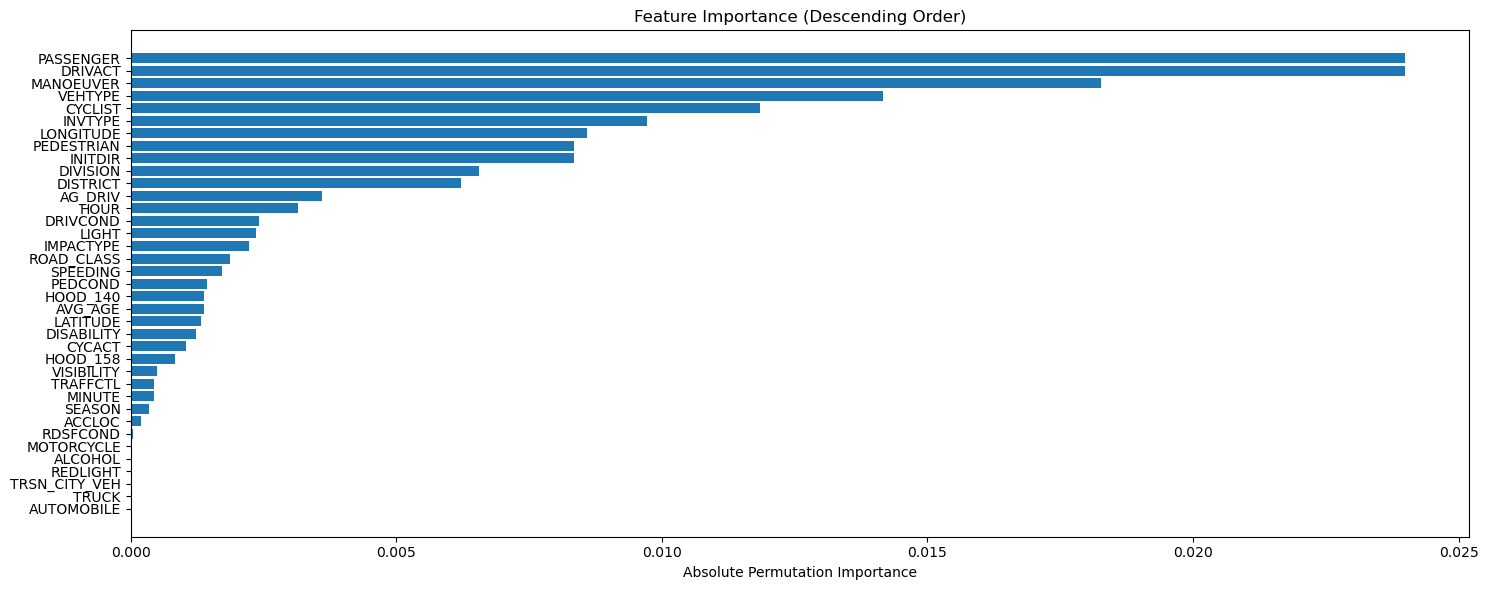

In [29]:
# Compute permutation importance
perm_importance = permutation_importance(best_model, X_train, y_train)

# Take absolute value and sort from high to low
abs_importance_mean = np.abs(perm_importance.importances_mean)
sorted_idx = np.argsort(abs_importance_mean)[::-1]  # Descending order

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": np.array(feature_names)[sorted_idx],
    "Importance": abs_importance_mean[sorted_idx],
})

# Save to CSV
importance_df.to_csv("feature_importance.csv", index=False)

# Print DataFrame
print(importance_df)

# Plot
plt.figure(figsize=(15, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Absolute Permutation Importance")
plt.title("Feature Importance (Descending Order)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.tight_layout()
plt.show()


**Feature Elimination using RFE**

In [24]:
from sklearn.feature_selection import RFE

X_train_transformed = preprocessor.fit_transform(X_train)

# Get transformed feature names
num_features_transformed = preprocessor.named_transformers_['num'].get_feature_names_out()
cat_features_transformed = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out()
all_transformed_features = np.concatenate([num_features_transformed, cat_features_transformed])

# Extract the SVC model from the pipeline
svc_model = best_model.named_steps['svm']

# Perform RFE
rfe = RFE(estimator=svc_model, n_features_to_select=150)
rfe.fit(X_train_transformed, y_train)

# Get selected and eliminated features
selected_features = all_transformed_features[rfe.support_]
eliminated_features = all_transformed_features[~rfe.support_]

# Print results
print("\nSelected Features:")
print(selected_features.tolist())

print("\nEliminated Features:")
print(eliminated_features.tolist())



Selected Features:
['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY', 'DIVISION', 'AVG_AGE', 'HOUR', 'x0_Collector', 'x0_Expressway', 'x0_Expressway Ramp', 'x0_Laneway', 'x0_Local', 'x0_Major Arterial', 'x0_Major Arterial ', 'x0_Minor Arterial', 'x0_Other', 'x0_Pending', 'x1_Etobicoke York', 'x1_North York', 'x1_Scarborough', 'x1_Toronto and East York', 'x1_Unknown', 'x2_At Intersection', 'x2_At/Near Private Drive', 'x2_Intersection Related', 'x2_Laneway', 'x2_Non Intersection', 'x2_Underpass or Tunnel', 'x3_No Control', 'x3_No_Control', 'x3_Pedestrian Crossover', 'x3_Stop Sign', 'x3_Traffic Controller', 'x3_Traffic Gate', 'x3_Traffic Signal', 'x4_Clear', 'x4_Drifting Snow', 'x4_Freezing Rain', 'x4_Other', 'x4_Rain', 'x4_Snow', 'x5_Dark', 'x5_Dawn', 'x5_Dawn, artificial', 'x5_Daylight', 'x5_Daylight, artificial', 'x5_Dusk', 'x5_Dusk, artificial', 'x6_Ice', 'x6_Loose Sand or Gravel', '

**Extracting Original Columns**

In [25]:
# Initialize sets to store mapped selected and eliminated features
selected_features_original = set()
eliminated_features_original = set()

def process_features(features, feature_names, cat_features):
    processed_features = set()

    for feature in features:
        if feature in feature_names:
            processed_features.add(feature)
        elif feature.startswith('x'):
            idx = int(feature[1:].split('_')[0])  
            processed_features.add(cat_features[idx])

    return processed_features

# Process selected and eliminated features
selected_features_original = process_features(selected_features, feature_names, cat_features)
eliminated_features_original = process_features(eliminated_features, feature_names, cat_features)

# Remove selected features from eliminated features 
eliminated_features_original -= selected_features_original

# Print results
print("\nTop 30 RFE Features:")
print(list(selected_features_original)[:30])

print("\nLeast Important RFE Features:")
print(list(eliminated_features_original) + list(selected_features_original)[30:])




Top 30 RFE Features:
['CYCLIST', 'ROAD_CLASS', 'RDSFCOND', 'HOUR', 'REDLIGHT', 'PEDESTRIAN', 'AG_DRIV', 'VISIBILITY', 'TRUCK', 'DIVISION', 'SPEEDING', 'DRIVACT', 'DRIVCOND', 'MANOEUVER', 'PASSENGER', 'ACCLOC', 'IMPACTYPE', 'LIGHT', 'AUTOMOBILE', 'TRAFFCTL', 'VEHTYPE', 'DISTRICT', 'CYCACT', 'PEDCOND', 'INITDIR', 'MOTORCYCLE', 'DISABILITY', 'INVTYPE', 'ALCOHOL', 'AVG_AGE']

Least Important RFE Features:
['HOOD_158', 'LATITUDE', 'HOOD_140', 'LONGITUDE', 'SEASON', 'MINUTE', 'TRSN_CITY_VEH']


**Top 30 RFE Features with Feature Importance**


Top 30 RFE Selected Features with Importance:
       Feature  Importance Mean  Importance Std
0      CYCLIST        -0.011405        0.001927
2     DISTRICT        -0.003258        0.002651
4        LIGHT        -0.002271        0.001183
5     SPEEDING        -0.002222        0.001918
6      AVG_AGE        -0.001481        0.001024
8       CYCACT        -0.000741        0.000349
10        HOUR        -0.000099        0.000458
11     ALCOHOL         0.000000        0.000000
12    REDLIGHT         0.000000        0.000000
14       TRUCK         0.000000        0.000000
15  MOTORCYCLE         0.000000        0.000000
16  AUTOMOBILE         0.000000        0.000000
17  VISIBILITY         0.000197        0.000185
18      ACCLOC         0.000247        0.001070
19    RDSFCOND         0.000543        0.000425
20    TRAFFCTL         0.000642        0.000576
21  ROAD_CLASS         0.001234        0.000662
22    DRIVCOND         0.001432        0.001365
23     PEDCOND         0.001530        0.

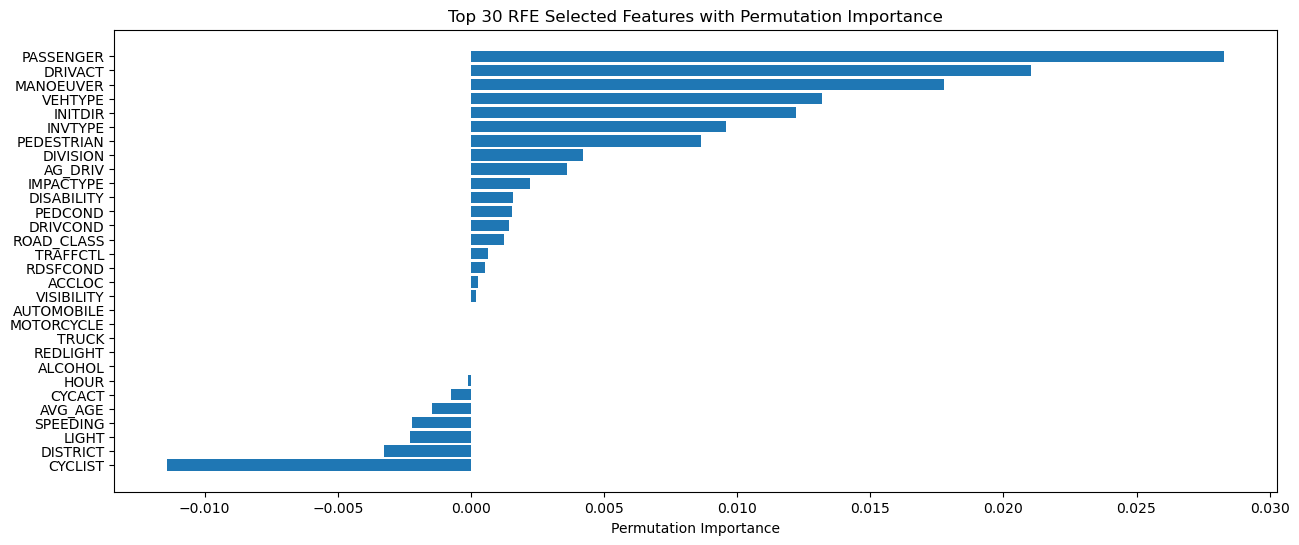

In [31]:
# Get the top 30 RFE-selected features
top_30_rfe_features = list(selected_features_original)[:30]

# Filter the importance dataframe to show only the RFE-selected features
rfe_importance_df = importance_df[importance_df['Feature'].isin(top_30_rfe_features)]

print("\nTop 30 RFE Selected Features with Importance:")
print(rfe_importance_df)

# Plot the top 30 RFE selected features with their importance
plt.figure(figsize=(15, 6))
plt.barh(rfe_importance_df["Feature"], rfe_importance_df["Importance Mean"])
plt.xlabel("Permutation Importance")
plt.title("Top 30 RFE Selected Features with Permutation Importance")
plt.show()